In [35]:
# Import libraries 
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

In [36]:
# Read the dataframe
books = pd.read_csv('books.csv', encoding='latin-1', sep=';',on_bad_lines='skip')
ratings = pd.read_csv('ratings.csv', encoding='latin-1', sep=';',on_bad_lines='skip')
users = pd.read_csv('users.csv', encoding='latin-1', sep=';',on_bad_lines='skip')

In [37]:
# Check for the null values
print("\nMissing values")
print('Books: ', books.isnull().sum())
print('Users: ', users.isnull().sum())
print('Ratings: ', ratings.isnull().sum())


Missing values
Books:  ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
Users:  User-ID          0
Location         0
Age         110762
dtype: int64
Ratings:  User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [38]:
# Merged data frame
merged_df = ratings.merge(books, on='ISBN')
full_df = merged_df.merge(users, on='User-ID')

In [39]:
# Basic statistics 
print('Rating Stats: ')
pd.set_option('display.float_format','{:.0f}'.format)
ratings['Book-Rating'].describe()

Rating Stats: 


count   1149780
mean          3
std           4
min           0
25%           0
50%           0
75%           7
max          10
Name: Book-Rating, dtype: float64

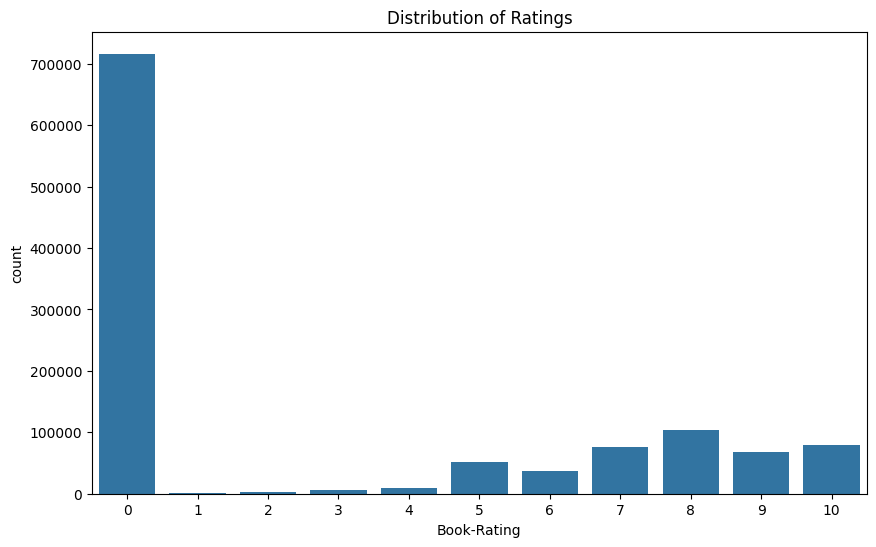

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.countplot(data=ratings, x='Book-Rating')
plt.title('Distribution of Ratings')
plt.show()

In [41]:
# Check user activity
user_activity = ratings['User-ID'].value_counts()
book_popularity = ratings['ISBN'].value_counts()

In [42]:
# Check User activity and book popularity
print(f'Total Users: ',len(user_activity))
print(f"Total books: ", len(book_popularity))
print(f"Average ratings per user: {user_activity.mean():.2f}")

Total Users:  105283
Total books:  340556
Average ratings per user: 10.92


# Collaborative Filtering Approach

In [43]:
# Import libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [44]:
ratings = ratings[ratings['Book-Rating']>2]

In [46]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [49]:
# Creat sparse matrix 

def create_sparse_marix(ratings):
    user_ids = ratings['User-ID'].unique()
    book_ids = ratings['ISBN'].unique()

    user_id_map = {id: i for i, id in enumerate(user_ids)}
    book_id_map = {id:i for i, id in enumerate(book_ids)}

    rows = [user_id_map[user] for user in ratings['User-ID']] 
    cols = [book_id_map[book] for book in ratings['ISBN']]
    data = ratings['Book-Rating'].values

    sparse_matrix = csr_matrix((data, (rows,cols)), shape=(len(user_ids),len(book_ids)))

    return sparse_matrix, user_id_map, book_id_map


A sparse matrix is a matrix in which most of the elements are zero, and storing all the zeros can be inefficient in terms of both memory usage and computational resources. The CSR format helps to address this issue by storing only the non-zero elements and their positions in a more compact way.

In the CSR format, the matrix is represented using three arrays:

Data: A 1D array that contains all the non-zero values in the matrix, stored in row-major order (i.e., row by row).

Indices: A 1D array that holds the column indices of the non-zero values. It corresponds to the indices of the Data array, meaning each value in the Data array is associated with a column index.

Indptr: A 1D array that points to the start of each row in the Data array. This array helps in locating the beginning of the non-zero elements for each row.

In [50]:
sparse_ratings, user_map, book_map = create_sparse_marix(ratings)

In [57]:
sparse_ratings.shape

(77152, 184398)

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

def user_based_recommendation_simple(sparse_matrix, user_map, book_map, user_id, n_recommendations=10, sample_size=1000):
    '''
    Simplified user-based recommendation with better error handling
    '''
    if user_id not in user_map:
        print('User not found in dataset')
        return []
    
    user_idx = user_map[user_id]
    
    # Get user's ratings
    user_ratings = sparse_matrix[user_idx].toarray().flatten()
    
    # Sample users for similarity calculation (always include target user)
    if sparse_matrix.shape[0] > sample_size:
        # Get random sample including our user
        other_users = np.setdiff1d(np.arange(sparse_matrix.shape[0]), [user_idx])
        sampled_other_users = np.random.choice(other_users, sample_size-1, replace=False)
        sampled_users = np.append(sampled_other_users, user_idx)
    else:
        sampled_users = np.arange(sparse_matrix.shape[0])
    
    print(f"Calculating similarities for {len(sampled_users)} users...")
    
    # Calculate similarity only for sampled users
    user_similarity = cosine_similarity(sparse_matrix[sampled_users])
    
    # Find our user's position in the sampled users
    user_pos = np.where(sampled_users == user_idx)[0]
    if len(user_pos) == 0:
        print("Error: User not found in sample")
        return []
    
    user_pos = user_pos[0]
    user_sim = user_similarity[user_pos]
    
    # Get similar users (excluding the user itself)
    similar_user_indices = np.argsort(user_sim)[::-1][1:11]  # Top 10 similar users
    similar_users_global = sampled_users[similar_user_indices]  # Convert to global indices
    
    print(f"Found {len(similar_users_global)} similar users")
    
    # Get books rated by similar users but not by our user
    similar_users_ratings = sparse_matrix[similar_users_global].mean(axis=0).A1
    
    # Mask books already rated by user
    similar_users_ratings[user_ratings > 0] = 0
    
    # Get top recommendations (only books with positive predicted ratings)
    valid_indices = np.where(similar_users_ratings > 0)[0]
    if len(valid_indices) == 0:
        print("No recommendations found - try increasing sample size")
        return []
    
    # Sort by predicted rating and get top N
    sorted_indices = valid_indices[np.argsort(similar_users_ratings[valid_indices])[::-1]]
    top_indices = sorted_indices[:n_recommendations]
    
    # Convert back to Book IDs
    book_id_map_reverse = {v: k for k, v in book_map.items()}
    recommended_books = [book_id_map_reverse[idx] for idx in top_indices if idx in book_id_map_reverse]
    
    print(f"Generated {len(recommended_books)} recommendations")
    return recommended_books

In [72]:
def test_user_based_recommendation():

    user_rating_counts = ratings['User-ID'].value_counts()

    # Find users with atleat 10 ratings for better recommedations
    active_users = np.random.choice(user_rating_counts[user_rating_counts>=2].index)

    if len(active_users)>0:
        test_user = active_users[0]
        print(f"Testing with user {test_user} who has {user_rating_counts[test_user]} ratings")

        recommendations = user_based_recommendation_simple(sparse_ratings, user_map, book_map, test_user, 5)

        print(f"Recommended books (ISBN): {recommendations}")

        return recommendations
    else:
        print("No active users found")

test_user_based_recommendation()

TypeError: object of type 'numpy.int64' has no len()

In [ ]:
sparse_ratings.sha

(77152, 184398)